In [1]:
import pandas as pd
import os
import numpy as np 
from stable_baselines3.common.logger import configure
import matplotlib.pyplot as pltmodel_sac

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

%matplotlib inline


In [2]:
import torch

torch.cuda.is_available()

True

In [12]:
check_and_make_directories([TRAINED_MODEL_DIR])

In [2]:
train = pd.read_csv('prepared_csv/russel1000_train_data.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']



In [3]:
# numpy_finrl_env.py
import numpy as np
import gymnasium as gym
from gymnasium.spaces import Box
from typing import Optional, Sequence, Union, Dict
from stable_baselines3.common.vec_env import DummyVecEnv
from collections import deque



# -------------------------
# Helper: normalize buy/sell cost inputs
# -------------------------
def _to_array_or_broadcast(x, length, dtype=np.float32):
    if np.isscalar(x):
        return np.full(length, float(x), dtype=dtype)
    arr = np.array(x, dtype=dtype)
    if arr.shape[0] != length:
        raise ValueError(f"Expected length {length} or scalar for cost lists; got {arr.shape}")
    return arr

# -------------------------
# The NumPy-based StockTradingEnv
# -------------------------

class NumpyStockTradingEnv(gym.Env):
    """
    NumPy-only, FinRL-compatible StockTradingEnv replacement.
    """
    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        price_array: np.ndarray,              # shape (T, N)
        tech_array: np.ndarray,               # shape (T, N, F) or None
        turbulence_array: Optional[np.ndarray] = None,  # shape (T,)
        hmax: int = 100,
        initial_amount: float = 1_000_000,
        num_stock_shares: Union[float, Sequence[float]] = 0,
        buy_cost_pct: Union[float, Sequence[float]] = 0.001,
        sell_cost_pct: Union[float, Sequence[float]] = 0.001,
        state_space: Optional[int] = None,
        stock_dim: Optional[int] = None,
        tech_indicator_list: Optional[Sequence[str]] = None,
        action_space: Optional[int] = None,
        reward_scaling: float = 1e-4,
        allow_negative_cash: bool = False,
        max_stock_holding: Optional[Union[float, Sequence[float]]] = None,
        # FinRL risk controls
        turbulence_threshold: Optional[float] = None,
        risk_indicator_col: Optional[str] = None,
        # Optional dates for info
        dates: Optional[Sequence] = None,
    ):
        super().__init__()

        assert price_array.ndim == 2, "price_array must be shape (T, N)"
        self.prices = price_array.astype(np.float32)
        self.T, self.N = self.prices.shape

        if tech_array is None:
            self.tech = np.zeros((self.T, self.N, 0), dtype=np.float32)
            self.F = 0
        else:
            assert tech_array.ndim == 3, "tech_array must be shape (T,N,F)"
            self.tech = tech_array.astype(np.float32)
            self.F = self.tech.shape[2]

        if turbulence_array is None:
            self.turbulence = np.zeros(self.T, dtype=np.float32)
        else:
            self.turbulence = turbulence_array.astype(np.float32)
            assert len(self.turbulence) == self.T

        # Config
        self.hmax = int(hmax)
        self.initial_amount = float(initial_amount)
        self.reward_scaling = float(reward_scaling)
        self.allow_negative_cash = bool(allow_negative_cash)

        self.stock_dim = self.N if stock_dim is None else int(stock_dim)
        assert self.stock_dim == self.N, "stock_dim mismatch with price_array"

        if np.isscalar(num_stock_shares):
            self.init_holdings = np.full(self.N, float(num_stock_shares), dtype=np.float32)
        else:
            arr = np.array(num_stock_shares, dtype=np.float32)
            assert arr.shape[0] == self.N
            self.init_holdings = arr

        self.buy_cost_pct = _to_array_or_broadcast(buy_cost_pct, self.N)
        self.sell_cost_pct = _to_array_or_broadcast(sell_cost_pct, self.N)

        if max_stock_holding is None:
            self.max_stock_holding = np.full(self.N, np.inf, dtype=np.float32)
        else:
            self.max_stock_holding = _to_array_or_broadcast(max_stock_holding, self.N)

        self.action_dim = self.N if action_space is None else int(action_space)
        assert self.action_dim == self.N, "action_space mismatch with price_array"
        self.action_space = Box(low=-1.0, high=1.0, shape=(self.action_dim,), dtype=np.float32)

        # Observation space matches FinRL layout
        obs_len = 1 + self.N + self.N + (self.N * self.F) + 1
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(obs_len,), dtype=np.float32)

        # Risk controls (FinRL-style)
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col  # for parity; not used directly here

        # Dates for info
        self.dates = np.array(dates) if dates is not None else None

        self.date_memory = []
        self.asset_memory = []
        self.actions_memory = []

        # logs
        self.last_action = np.zeros(self.N, dtype=np.int32)

        self.tech_indicator_list = list(tech_indicator_list) if tech_indicator_list else []
        self.state_space = state_space if state_space is not None else obs_len

        self.reset_internal_store()

    def reset_internal_store(self):
        self.day = 0
        self.cash = float(self.initial_amount)
        self.holdings = self.init_holdings.copy().astype(np.float32)
        self.prev_portfolio_value = float(self.cash + np.sum(self.holdings * self.prices[0]))
        self.total_step = 0
        self.last_action = np.zeros(self.N, dtype=np.int32)

        self.date_memory = []
        self.asset_memory = []
        self.actions_memory = []

        self.ret_window = deque(maxlen=60)
        self.pv_window = deque(maxlen=60)
        self.weights_prev = np.zeros(self.N)
        self.pv_window.append(self.prev_portfolio_value)

    def reset(self, seed: Optional[int] = None):
        if seed is not None:
            np.random.seed(seed)
        self.reset_internal_store()
        return self._get_obs(), {}

    def _get_obs(self):
        price_today = self.prices[self.day]
        tech_today = self.tech[self.day].reshape(-1)
        turb = np.array([self.turbulence[self.day]], dtype=np.float32)
        obs = np.concatenate([
            np.array([self.cash], dtype=np.float32),
            self.holdings.astype(np.float32),
            price_today.astype(np.float32),
            tech_today.astype(np.float32),
            turb
        ]).astype(np.float32)
        return obs

    def _apply_risk_controls(self, shares_delta: np.ndarray) -> np.ndarray:
        # If turbulence exceeds threshold, liquidate and block buys (FinRL behavior)
        if self.turbulence_threshold is not None and self.turbulence[self.day] > float(self.turbulence_threshold):
            # sell all current holdings, ignore buys
            forced_sell = -np.floor(self.holdings).astype(np.int32)
            return forced_sell
        return shares_delta
    
    def _compute_reward(self, portfolio_value):
        # ----- Instant log return -----
        V_t = self.prev_portfolio_value
        V_t1 = portfolio_value
        instant_ret = np.log((V_t1 + 1e-12) / (V_t + 1e-12))

        # store for rolling stats
        self.ret_window.append(instant_ret)
        self.pv_window.append(portfolio_value)

        # ----- Rolling volatility (20-window) -----
        if len(self.ret_window) >= 20:
            rolling_vol = np.std(list(self.ret_window)[-20:])
        else:
            rolling_vol = 0.0

        # ----- Rolling max drawdown (60-window) -----
        pv_arr = np.array(self.pv_window)
        if len(pv_arr) >= 2:
            peak = np.maximum.accumulate(pv_arr)
            drawdowns = (peak - pv_arr) / (peak + 1e-12)
            rolling_dd = float(np.max(drawdowns))
        else:
            rolling_dd = 0.0

        # ----- Turnover penalty -----
        # weights = normalized holdings by portfolio value
        prices = self.prices[self.day]
        holdings_value = self.holdings * prices
        portfolio_v = holdings_value.sum() + self.cash
        weights = holdings_value / (portfolio_v + 1e-12)

        turnover = np.sum(np.abs(weights - self.weights_prev))
        self.weights_prev = weights.copy()

        # ----- Composite Reward -----
        lambda_vol = 0.25
        lambda_dd = 0.5
        lambda_turn = 1e-4

        raw_reward = (
            instant_ret
            - lambda_vol * rolling_vol
            - lambda_dd * rolling_dd
            - lambda_turn * turnover
        )

        return float(raw_reward * self.reward_scaling)
    

    def step(self, action: np.ndarray):
        assert isinstance(action, np.ndarray), "action must be numpy array"
        assert action.shape == (self.N,), f"action shape must be {(self.N,)}, got {action.shape}"

        prices = self.prices[self.day]

        # scale action to integer share deltas
        raw_shares = (np.clip(action, -1.0, 1.0) * float(self.hmax)).astype(np.float32)
        shares_delta = np.trunc(raw_shares).astype(np.int32)

        # risk controls
        shares_delta = self._apply_risk_controls(shares_delta)
        self.last_action = shares_delta.copy()

        # SELL first
        sell_units = np.abs(np.minimum(shares_delta, 0)).astype(np.int32)
        if np.any(sell_units):
            actual_sell = np.minimum(sell_units, self.holdings.astype(np.int32))
            revenue = (actual_sell.astype(np.float32) * prices) * (1.0 - self.sell_cost_pct)
            self.cash += float(np.sum(revenue))
            self.holdings = self.holdings - actual_sell.astype(np.float32)

        # BUY next (skip if risk control forced full liquidation)
        buy_units = shares_delta.clip(min=0).astype(np.int32)
        if np.any(buy_units):
            space_left = (self.max_stock_holding - self.holdings).clip(min=0).astype(np.int32)
            actual_buy = np.minimum(buy_units, space_left)
            cost_wo_fee = actual_buy.astype(np.float32) * prices
            cost_w_fee = cost_wo_fee * (1.0 + self.buy_cost_pct)
            total_cost = float(np.sum(cost_w_fee))

            if not self.allow_negative_cash and total_cost > self.cash and np.sum(cost_w_fee) > 0.0:
                scale = float(self.cash / total_cost)
                if scale < 1e-8:
                    actual_buy = np.zeros_like(actual_buy)
                    total_cost = 0.0
                else:
                    scaled = np.floor(actual_buy.astype(np.float32) * scale).astype(np.int32)
                    actual_buy = scaled
                    cost_wo_fee = actual_buy.astype(np.float32) * prices
                    cost_w_fee = cost_wo_fee * (1.0 + self.buy_cost_pct)
                    total_cost = float(np.sum(cost_w_fee))

            self.cash -= total_cost
            self.holdings = self.holdings + actual_buy.astype(np.float32)

        # advance time
        self.day += 1
        self.total_step += 1
        done = (self.day >= (self.T - 1))

        current_prices = self.prices[self.day]
        portfolio_value = float(self.cash + np.sum(self.holdings * current_prices))

        reward = self._compute_reward(portfolio_value)
        self.prev_portfolio_value = portfolio_value

        # raw_reward = portfolio_value - self.prev_portfolio_value
        # self.prev_portfolio_value = portfolio_value
        # reward = float(raw_reward) * self.reward_scaling

        date_val = None if self.dates is None else self.dates[self.day]
        self.date_memory.append(date_val if date_val is not None else int(self.day))
        self.asset_memory.append(portfolio_value)
        self.actions_memory.append(self.last_action.copy())

        info = {
            "total_assets": portfolio_value,
            "cash": float(self.cash),
            "holdings": self.holdings.copy(),
            "day": int(self.day),
            "date": None if self.dates is None else self.dates[self.day],
            "action": self.last_action.copy(),  # FinRL often logs actions externally; include for convenience
        }

        obs = self._get_obs()
        return obs, reward, done, False, info
    
    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs
    
    def save_asset_memory(self):
        import pandas as pd
        return pd.DataFrame({"date": self.date_memory, "account_value": self.asset_memory})

    def save_action_memory(self):
        import pandas as pd
        df = pd.DataFrame(self.actions_memory)
        if hasattr(self, "stock_dim") and df.shape[1] == self.stock_dim:
            # try to attach tickers if provided via tech arrays metadata is unavailable; leave numeric cols otherwise
            pass
        # attach date index
        df.insert(0, "date", self.date_memory)
        return df


In [4]:
import pandas as pd
import numpy as np
from typing import List, Tuple

def prepare_numpy_arrays_from_finrl_df(
    df: pd.DataFrame,
    tic_list: List[str],
    date_sorted: bool = True,
    tech_indicator_list: Optional[List[str]] = None,
    price_col: str = "close",
    turbulence_col: Optional[str] = "turbulence",
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Convert a FinRL multi-ticker long-format DataFrame (columns at least: date, tic, close, indicators...)
    into:
      - price_array (T, N)
      - tech_array (T, N, F)
      - turbulence_array (T,)
      - dates (T,)  -- array of date strings
    tic_list: ordered list of tickers to include (N)
    """
    if not date_sorted:
        df = df.sort_values("date")

    # pivot prices: rows = date, cols = tic_list
    price_pivot = df.pivot(index="date", columns="tic", values=price_col)
    # ensure ticker order
    price_pivot = price_pivot.reindex(columns=tic_list)
    # forward fill/backfill missing data
    price_pivot = price_pivot.ffill().bfill().fillna(0.0)

    dates = price_pivot.index.tolist()
    price_array = price_pivot.values.astype(np.float32)  # shape (T, N)

    # tech indicators
    if tech_indicator_list:
        # build (T, N, F)
        tech_list = []
        for ind in tech_indicator_list:
            pivot = df.pivot(index="date", columns="tic", values=ind)
            pivot = pivot.reindex(columns=tic_list)
            pivot = pivot.ffill().bfill().fillna(0.0)
            tech_list.append(pivot.values.astype(np.float32))  # shape (T,N)
        # stack to shape (T, N, F)
        tech_array = np.stack(tech_list, axis=2)
    else:
        tech_array = np.zeros((price_array.shape[0], price_array.shape[1], 0), dtype=np.float32)

    # turbulence
    if turbulence_col and turbulence_col in df.columns:
        turb_series = df.drop_duplicates(subset=["date"]).set_index("date")[turbulence_col]
        turb_series = turb_series.reindex(index=price_pivot.index).fillna(0.0)
        turbulence_array = turb_series.values.astype(np.float32)
    else:
        turbulence_array = np.zeros(price_array.shape[0], dtype=np.float32)

    return price_array, tech_array, turbulence_array, np.array(dates)


In [5]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
import pandas as pd

tic_list = sorted(train['tic'].unique().tolist())  # ordered list of tickers to include

INDICATORS = [
    'day',
    'macd',
    'boll_ub',
    'boll_lb',
    'rsi_30',
    'cci_30',
    'dx_30',
    'close_30_sma',
    'close_60_sma',
    'vix',
]
price_array, tech_array, turbulence_array, dates = prepare_numpy_arrays_from_finrl_df(
    train, tic_list, tech_indicator_list=INDICATORS, price_col="close", turbulence_col="turbulence"
)

# env kwargs (example)
env_kwargs = {
    "price_array": price_array,
    "tech_array": tech_array,
    "turbulence_array": turbulence_array,
    "hmax": 100,
    "initial_amount": 1_000_000,
    "num_stock_shares": 0,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": None,
    "stock_dim": len(tic_list),
    "tech_indicator_list": INDICATORS,
    "action_space": len(tic_list),
    "reward_scaling": 1e-4,
    "allow_negative_cash": False,
    "max_stock_holding": np.full(len(tic_list), 1e9),}

# Single env (low RAM)
N_ENVS = 2
make_env = lambda: NumpyStockTradingEnv(**env_kwargs)
env = SubprocVecEnv([make_env] * N_ENVS)


# FinRL env

In [ ]:
# stock_dimension = len(train.tic.unique())
# state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
# print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

# buy_cost_list = sell_cost_list = [0.001] * stock_dimension
# num_stock_shares = [0] * stock_dimension

# env_kwargs = {
#     "hmax": 100,
#     "initial_amount": 1_000_000,
#     "num_stock_shares": num_stock_shares,
#     "buy_cost_pct": buy_cost_list,
#     "sell_cost_pct": sell_cost_list,
#     "state_space": state_space,
#     "stock_dim": stock_dimension,
#     "tech_indicator_list": INDICATORS,
#     "action_space": stock_dimension,
#     "reward_scaling": 1e-4
# }


# e_train_gym = StockTradingEnv(df = train, **env_kwargs)
# env_train, _ = e_train_gym.get_sb_env()



Stock Dimension: 550, State Space: 5501


In [6]:
import numpy as np
from finrl.agents.stablebaselines3 import models as finrl_models
from stable_baselines3.common.callbacks import CallbackList

def _safe_on_rollout_end(self) -> bool:
    buffer = getattr(self.model, "rollout_buffer", None)
    if buffer is None:
        buffer = getattr(self.model, "replay_buffer", None)

    rewards = None
    if buffer is not None and hasattr(buffer, "rewards"):
        rewards = np.array(buffer.rewards).flatten()
    elif isinstance(self.locals, dict):
        rewards = self.locals.get("rewards") or self.locals.get("reward")
        if rewards is not None:
            rewards = np.array(rewards).flatten()

    if rewards is not None and rewards.size > 0:
        self.logger.record("train/reward_min", float(np.min(rewards)))
        self.logger.record("train/reward_mean", float(np.mean(rewards)))
        self.logger.record("train/reward_max", float(np.max(rewards)))
    else:
        self.logger.record("train/reward_min", None)
        self.logger.record("train/reward_mean", None)
        self.logger.record("train/reward_max", None)
    return True

finrl_models.TensorboardCallback._on_rollout_end = _safe_on_rollout_end

def _safe_train_model(model, tb_log_name, total_timesteps=50000, callbacks=None):
    base = finrl_models.TensorboardCallback()
    extra = []
    if callbacks:
        extra = callbacks if isinstance(callbacks, (list, tuple)) else [callbacks]
    combo = CallbackList([base, *extra]) if extra else base
    return model.learn(total_timesteps=total_timesteps, tb_log_name=tb_log_name, callback=combo)

finrl_models.DRLAgent.train_model = staticmethod(_safe_train_model)

# Agents

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
# agent = DRLAgent(env=env)
# PPO_PARAMS = {
#     "n_steps": 4096,
#     "ent_coef": 0.01,
#     "learning_rate": 0.00025,
#     "batch_size": 128,
# }
# model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)


# tmp_path = os.path.join(RESULTS_DIR, 'ppo')
# new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# model_ppo.set_logger(new_logger_ppo)

{'n_steps': 4096, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to results/ppo


/mnt/shared/miniconda3/envs/ml/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [7]:
agent = DRLAgent(env=env)
SAC_PARAMS = {
    "learning_rate": 3e-4,
    "batch_size": 128,
    "buffer_size": 140_000,
    "learning_starts": 5_000,
    "gamma": 0.99,
    "tau": 0.005,
}
model_sac = agent.get_model("sac", model_kwargs=SAC_PARAMS)


tmp_path = os.path.join(RESULTS_DIR, 'sac')
new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
model_sac.set_logger(new_logger_sac)

{'learning_rate': 0.0003, 'batch_size': 128, 'buffer_size': 140000, 'learning_starts': 5000, 'gamma': 0.99, 'tau': 0.005}
Using cuda device
Logging to results/sac


In [ ]:
# |    fps             | 10          |
# |    iterations      | 1           |
# |    time_elapsed    | 195         |
# |    total_timesteps | 2048   

In [8]:
trained_sac = agent.train_model(
    model=model_sac, 
    tb_log_name='sac_russel',
    total_timesteps=200_000
)

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 175       |
|    time_elapsed    | 107       |
|    total_timesteps | 18860     |
| train/             |           |
|    actor_loss      | 3.01e+05  |
|    critic_loss     | 1.66e+11  |
|    ent_coef        | 0.145     |
|    ent_coef_loss   | -564      |
|    learning_rate   | 0.0003    |
|    n_updates       | 6929      |
|    reward          | -1.55e-06 |
|    reward_max      | 2.22e-06  |
|    reward_mean     | -6.47e-07 |
|    reward_min      | -4.63e-05 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 147       |
|    time_elapsed    | 255       |
|    total_timesteps | 37720     |
| train/             |           |
|    actor_loss      | 1.29e+06  |
|    critic_loss     | 3.72e+13  |
|    ent_coef        | 0.0802    |
|    ent_coef_loss  

KeyboardInterrupt: 

In [ ]:
# trained_ppo = agent.train_model(
#     model=model_ppo, 
#     tb_log_name='ppo_russel',
#     total_timesteps=200_000
# )

-------------------------------------
| time/              |              |
|    fps             | 749          |
|    iterations      | 1            |
|    time_elapsed    | 10           |
|    total_timesteps | 8192         |
| train/             |              |
|    reward          | 0.00565      |
|    reward_max      | 7.9106627    |
|    reward_mean     | -0.016194992 |
|    reward_min      | -7.8574953   |
-------------------------------------


KeyboardInterrupt: 

In [ ]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac_russel_custom_reward_140k")

# Test

In [6]:
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3


trade = pd.read_csv('prepared_csv/russel1000_trade_data.csv')

trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo_russel", device='cpu')
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac_russel_custom_reward")


/mnt/shared/miniconda3/envs/ml/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 11.00GB > 6.11GB
  warnings.warn(


In [7]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


price_array, tech_array, turbulence_array, dates = prepare_numpy_arrays_from_finrl_df(
    trade, tic_list, tech_indicator_list=INDICATORS, price_col="close", turbulence_col="turbulence"
)

# env kwargs (example)
env_kwargs = {
    "price_array": price_array,
    "tech_array": tech_array,
    "turbulence_array": turbulence_array,
    "hmax": 100,
    "initial_amount": 1_000_000,
    "num_stock_shares": 0,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": None,
    "stock_dim": len(tic_list),
    "tech_indicator_list": INDICATORS,
    "action_space": len(tic_list),
    "reward_scaling": 1e-4,
    "allow_negative_cash": False,
    "max_stock_holding": np.full(len(tic_list), 1e9),
    "dates": dates,
}

# Single env (low RAM)
make_env = lambda: NumpyStockTradingEnv(**env_kwargs)
trade_env = NumpyStockTradingEnv(**env_kwargs)

# buy_cost_list = sell_cost_list = [0.001] * stock_dimension
# num_stock_shares = [0] * stock_dimension

# env_kwargs = {
#     "hmax": 100,
#     "initial_amount": 1000000,
#     "num_stock_shares": num_stock_shares,
#     "buy_cost_pct": buy_cost_list,
#     "sell_cost_pct": sell_cost_list,
#     "state_space": state_space,
#     "stock_dim": stock_dimension,
#     "tech_indicator_list": INDICATORS,
#     "action_space": stock_dimension,
#     "reward_scaling": 1e-4
# }


# e_trade_gym = StockTradingEnv(
#     df = trade, 
#     turbulence_threshold = 70,
#     risk_indicator_col='vix', 
#     **env_kwargs
# )

Stock Dimension: 550, State Space: 6601


In [10]:
print(len(trade_env.dates))

1571


In [8]:
from tqdm import tqdm

def DRL_numpy_prediction(model, environment, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    # state_memory=[] #add memory pool to store states

    test_env.reset()
    # max_steps = len(environment.df.index.unique()) - 1
    max_steps = environment.prices.shape[0] - 1
    print(max_steps)

    for i in range(environment.prices.shape[0]):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        # account_memory = test_env.env_method(method_name="save_asset_memory")
        # actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)
        # print(account_memory)


        if (
            i == max_steps - 2
        ):  # more descriptive condition for early termination to clarify the logic
            account_memory = test_env.env_method(method_name="save_asset_memory")
            actions_memory = test_env.env_method(method_name="save_action_memory")

            print(len(environment.asset_memory), len(test_env.env_method(method_name="save_asset_memory")), i)

        # add current state to state memory
        # state_memory=test_env.env_method(method_name="save_state_memory")
        

        if dones[0]:
            print("hit end!")
            break
    return account_memory[0], actions_memory[0]

In [9]:
df_account_value_ppo, df_actions_ppo = DRL_numpy_prediction(
    model=trained_ppo, 
    environment = trade_env
)

df_result_ppo = (
    df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
)

1570
1569 1 1568
hit end!


In [10]:
df_account_value_sac, df_actions_sac = DRL_numpy_prediction(
    model=trained_sac, 
    environment = trade_env
)

df_result_sac = (
    df_account_value_sac.set_index(df_account_value_sac.columns[0])
)

1570
1569 1 1568
hit end!


In [169]:
len(trade.index.unique())

1571

In [170]:
actions.index

RangeIndex(start=0, stop=1569, step=1)

In [161]:
# --- Build derived data ---
actions = df_actions_ppo.copy()                       # trades (positive buy, negative sell)
prices = trade.pivot(index="date", columns="tic", values="close").reindex(actions.index)

# If actions are trade deltas, cumulative shares = position
positions = actions.cumsum()
position_values = positions * prices
portfolio_value_calc = position_values.sum(axis=1)
account_value = df_account_value_ppo.set_index("date")["account_value"].reindex(actions.index)

cash_est = account_value - portfolio_value_calc
weights = position_values.div(portfolio_value_calc, axis=0).fillna(0)

# Sanity check
print("Computed portfolio vs reported (head):")
print(pd.DataFrame({
    "reported_account_value": account_value.head(5),
    "reconstructed_portfolio_value": portfolio_value_calc.head(5),
    "cash_est": cash_est.head(5)
}))

# --- Helper to mark buys/sells ---
def buy_sell_markers(series, threshold=0):
    buys = series[series > threshold]
    sells = series[series < -threshold]
    return buys, sells




ZeroDivisionError: float division by zero

NameError: name 'buy_sell_markers' is not defined

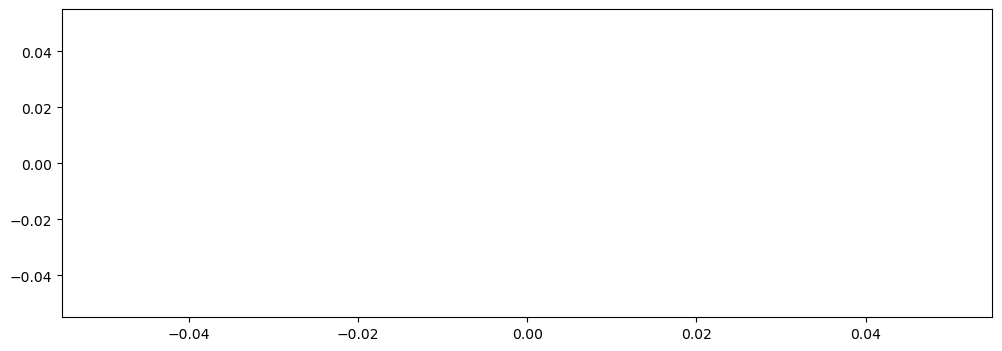

In [147]:
# Price + actions (markers) for a single ticker
import matplotlib.pyplot as plt

ticker = "PG"  # change as needed
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(prices.index, prices[ticker], label="Price", color="black")

buys, sells = buy_sell_markers(actions[ticker])
ax.scatter(buys.index, prices.loc[buys.index, ticker], marker="^", color="green", label="Buy", s=60)
ax.scatter(sells.index, prices.loc[sells.index, ticker], marker="v", color="red", label="Sell", s=60)

ax2 = ax.twinx()
ax2.plot(actions.index, actions[ticker], color="blue", alpha=0.3, label="Action (shares delta)")
ax.set_title(f"{ticker} Price and Trades")
ax.set_xlabel("Date"); ax.set_ylabel("Price"); ax2.set_ylabel("Shares Delta")
lines = ax.get_lines() + ax2.get_lines()
plt.legend(lines + [ax.collections[0], ax.collections[1]],
           [l.get_label() for l in lines] + ["Buy","Sell"], loc="upper left")
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

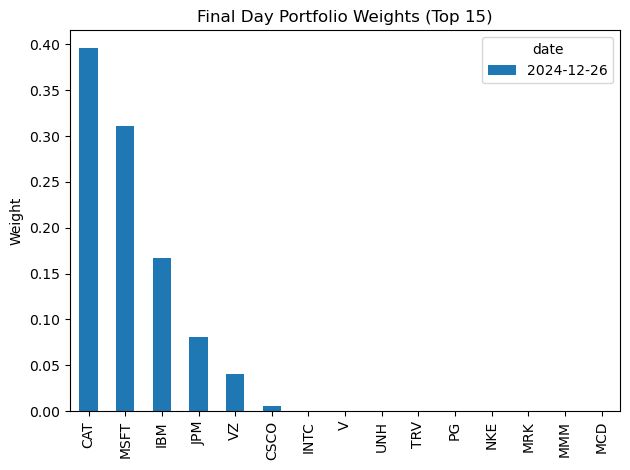

In [11]:
last_w = weights.tail(1).T.sort_values(by=weights.index[-1], ascending=False)
plt.figure(figsize=(10,5))
last_w.head(15).plot(kind="bar")
plt.title("Final Day Portfolio Weights (Top 15)")
plt.ylabel("Weight")
plt.tight_layout()
plt.show()

# Baseline

In [11]:
def stock_returns_compute(stock_price, rows, columns):
    stock_return = np.zeros([rows-1, columns])
    for j in range(columns):
        for i in range(rows-1): 
            stock_return[i,j]=(
                (stock_price[i+1, j]-stock_price[i,j])/stock_price[i,j]
            )* 100 
      
    return stock_return


def process_df_for_mvo(df):
    return df.pivot(index="date", columns="tic", values="close")

In [12]:
stock_data = process_df_for_mvo(train)
trade_data = process_df_for_mvo(trade)

In [13]:
ar_stock_prices = np.asarray(stock_data)
[rows, cols] = ar_stock_prices.shape
ar_returns = stock_returns_compute(ar_stock_prices, rows, cols)

mean_returns = np.mean(ar_returns, axis = 0)
cov_returns = np.cov(ar_returns, rowvar=False)
 
np.set_printoptions(precision=3, suppress = True)

In [14]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(mean_returns, cov_returns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(len(cleaned_weights_mean))])




last_price = np.array([1/p for p in stock_data.tail(1).to_numpy()[0]])
initial_portfolio = np.multiply(mvo_weights, last_price)



Portfolio_Assets = trade_data @ initial_portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result





,Mean Var
date,
2018-10-01,9.961285e+05
2018-10-02,9.909682e+05
2018-10-03,9.897895e+05
2018-10-04,9.836983e+05
2018-10-05,9.830748e+05
...,...
2024-12-20,2.632322e+06
2024-12-23,2.626360e+06
2024-12-24,2.650464e+06


# Results

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

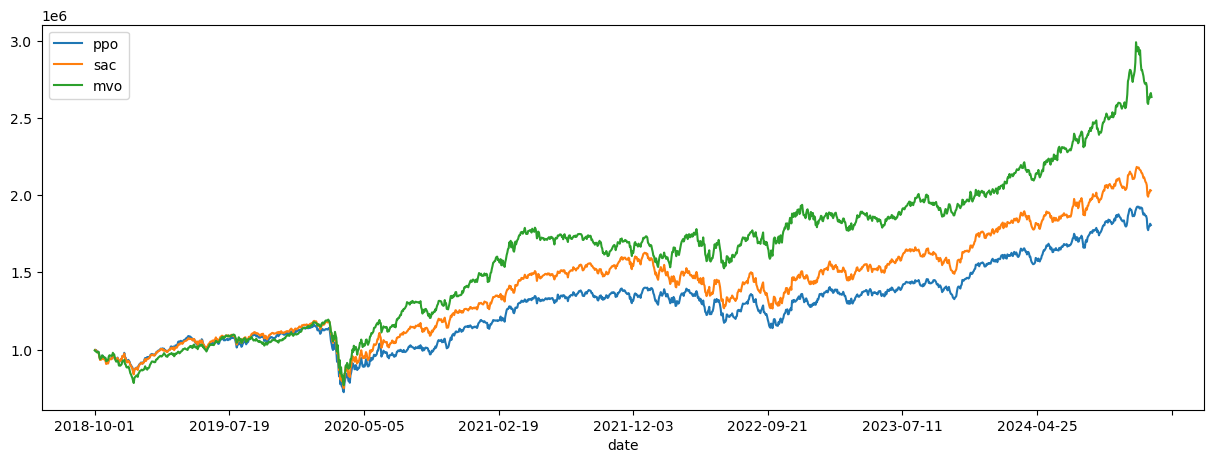

In [15]:
import matplotlib.pyplot as plt

result = pd.DataFrame(
    {
        "ppo": df_result_ppo["account_value"],
        "sac": df_result_sac["account_value"],
        "mvo": MVO_result["Mean Var"],
    }
)

plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()